## Bank Churn Prediction Project (Neural Network) - Prabhu 22Jan2021

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.


**Objective:**Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

In [1]:
!pip install tensorflow==2.0 # Install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
## Importing Libraries
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
project_path = '/content/drive/My Drive/Colab Notebooks/'

In [7]:
dataset_file = project_path + 'bank.csv'    # Import and read the csv data file 

In [8]:
data = pd.read_csv(dataset_file)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [10]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [12]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Feature Elimination

In [13]:
#Dropping columns "RowNumber", "CustomerId" and "Surname" which are unique and not required for evaluation (Feature Elimination)    
data = data.drop("RowNumber", axis = 1) 

In [14]:
data = data.drop("CustomerId", axis = 1)

In [15]:
data = data.drop("Surname", axis = 1)

In [16]:
data.head() # checking if the columns were dropped -- ok 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Bivariate Analysis

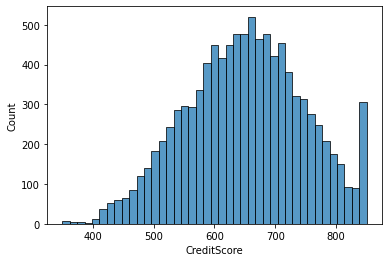

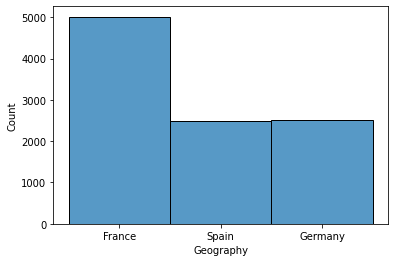

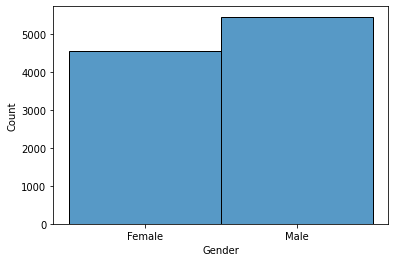

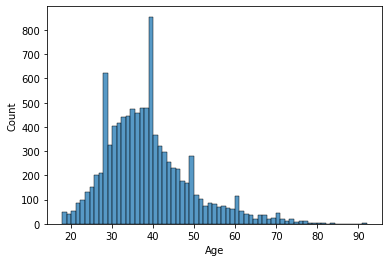

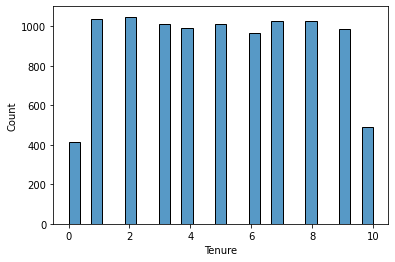

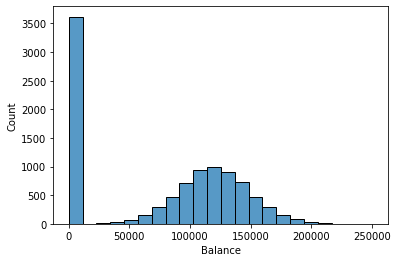

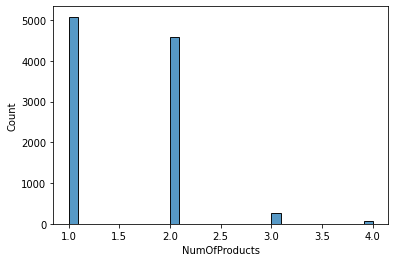

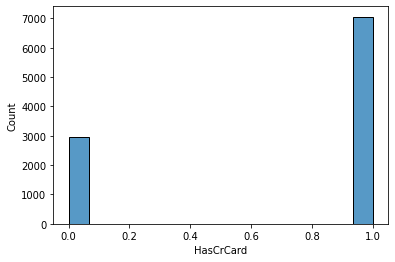

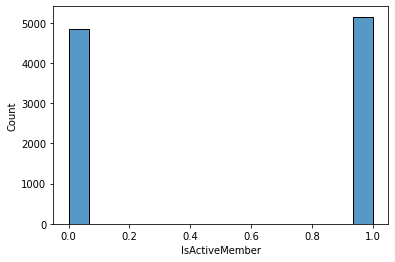

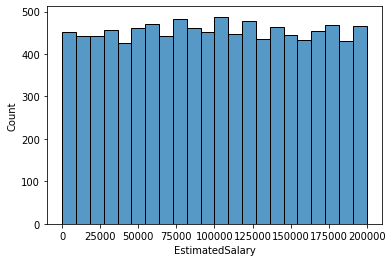

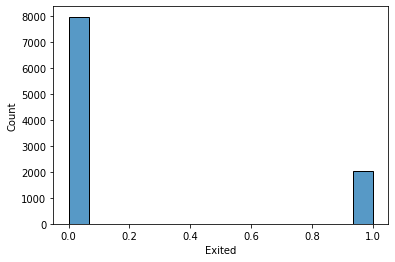

In [17]:
import seaborn as sns
for i in data.columns:
    sns.histplot(data[i])
    plt.show()
    # data is evenly spread no major outliers
    # analyzing the data set is good does not have major skewness the data set is good. Tenure with the bank is evenly spread. except some new customers and 10 year customers are slightly less.

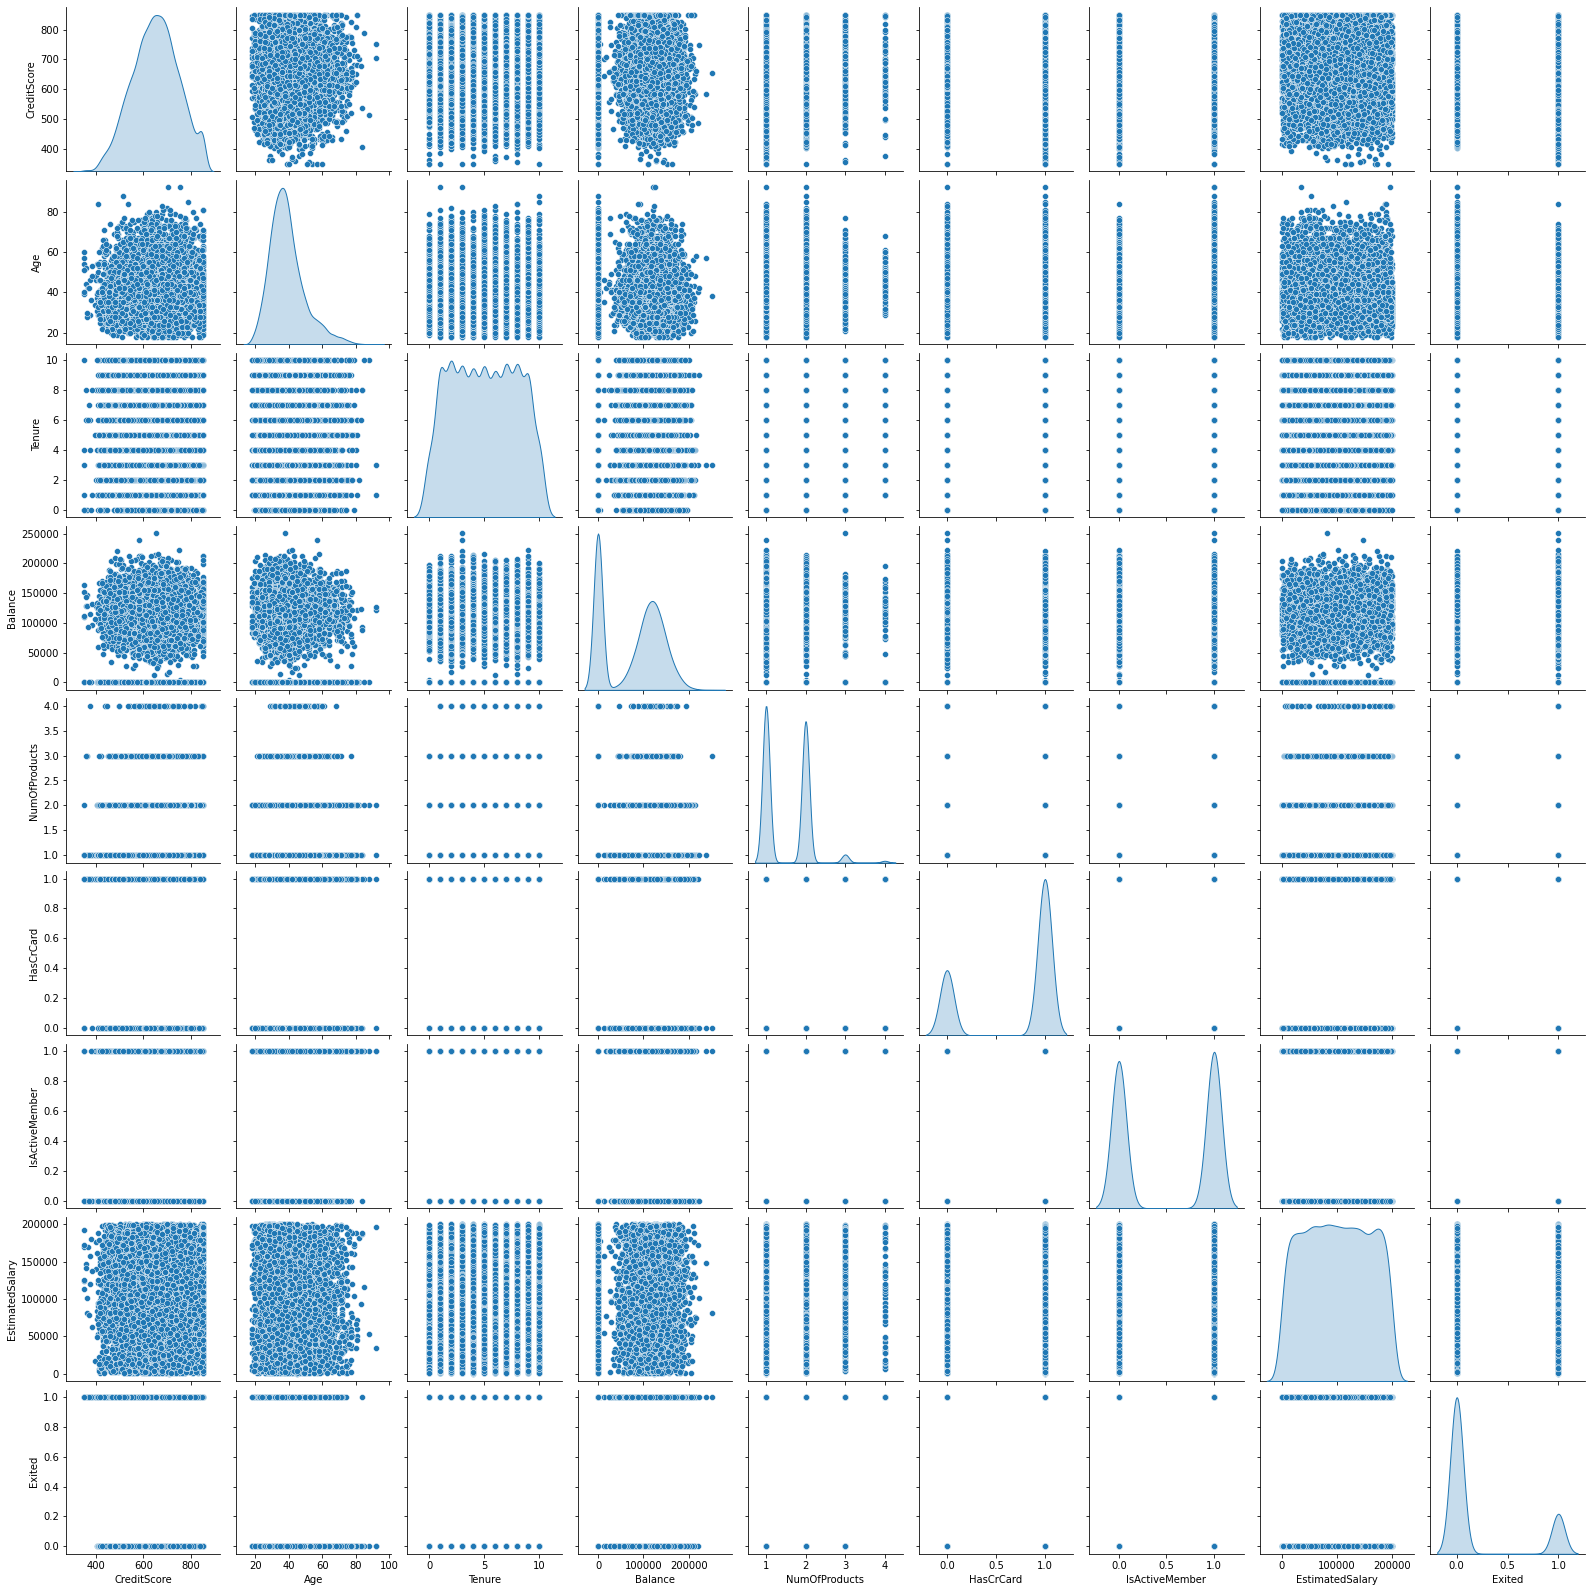

In [18]:
import seaborn as sns
sns.pairplot(data,diag_kind='kde')
plt.show()

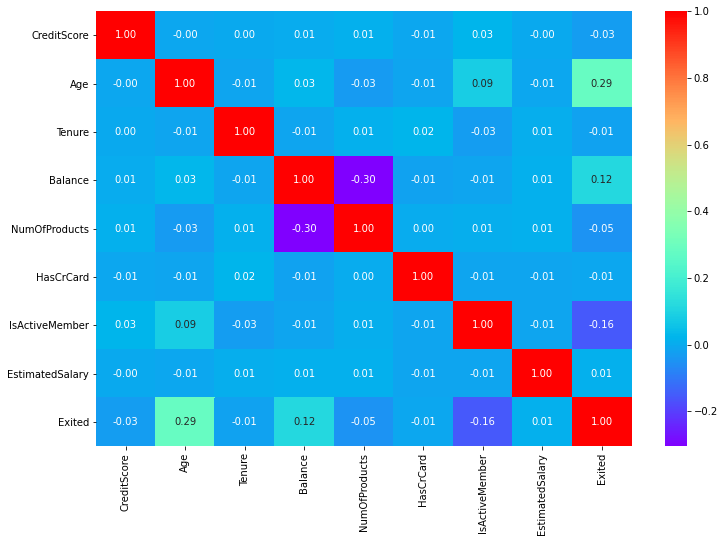

In [19]:
# Looking for correlation Heatmap  -- data is evenly spread no major outliers
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,fmt='.2f',cmap='rainbow', )
plt.show()

In [20]:
#just some basic preprocessing -- Normalizing the dataset
#creating dummy variables for the categorical features
data = pd.get_dummies(data)
data = data.astype('float64') # we will need to convert the dataset string data to float in order to be able to convert it into tensors later. This will help to distinguish arrange feature and target columns.
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,1.0,0.0,0.0,1.0,0.0
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0.0,0.0,1.0,1.0,0.0
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,1.0,0.0,0.0,1.0,0.0
3,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,1.0,0.0,0.0,1.0,0.0
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0,1.0,0.0,0.0,0.0,1.0
9996,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0,1.0,0.0,0.0,0.0,1.0
9997,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0,1.0,0.0,0.0,1.0,0.0
9998,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1.0,0.0,1.0,0.0,0.0,1.0


In [21]:
#Rearranging columns by putting target variable "Exited"  on the last column
data = data[['CreditScore','Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',  'Exited']]

In [22]:
data   # checking the rearranged columns  ---  are ok

,CreditScore,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,1.0,0.0,0.0,1.0,0.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,608.0,0.0,0.0,1.0,1.0,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,502.0,1.0,0.0,0.0,1.0,0.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,699.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,850.0,0.0,0.0,1.0,1.0,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,1.0,0.0,0.0,0.0,1.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0
9996,516.0,1.0,0.0,0.0,0.0,1.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0
9997,709.0,1.0,0.0,0.0,1.0,0.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0
9998,772.0,0.0,1.0,0.0,0.0,1.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1.0


In [23]:
data.info() # All objects have been converted into float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Geography_France   10000 non-null  float64
 2   Geography_Germany  10000 non-null  float64
 3   Geography_Spain    10000 non-null  float64
 4   Gender_Female      10000 non-null  float64
 5   Gender_Male        10000 non-null  float64
 6   Age                10000 non-null  float64
 7   Tenure             10000 non-null  float64
 8   Balance            10000 non-null  float64
 9   NumOfProducts      10000 non-null  float64
 10  HasCrCard          10000 non-null  float64
 11  IsActiveMember     10000 non-null  float64
 12  EstimatedSalary    10000 non-null  float64
 13  Exited             10000 non-null  float64
dtypes: float64(14)
memory usage: 1.1 MB


In [24]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Geography_France,10000.0,0.501400,0.500023,0.00,0.00,1.000,1.0000,1.00
Geography_Germany,10000.0,0.250900,0.433553,0.00,0.00,0.000,1.0000,1.00
Geography_Spain,10000.0,0.247700,0.431698,0.00,0.00,0.000,0.0000,1.00
Gender_Female,10000.0,0.454300,0.497932,0.00,0.00,0.000,1.0000,1.00
Gender_Male,10000.0,0.545700,0.497932,0.00,0.00,1.000,1.0000,1.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00


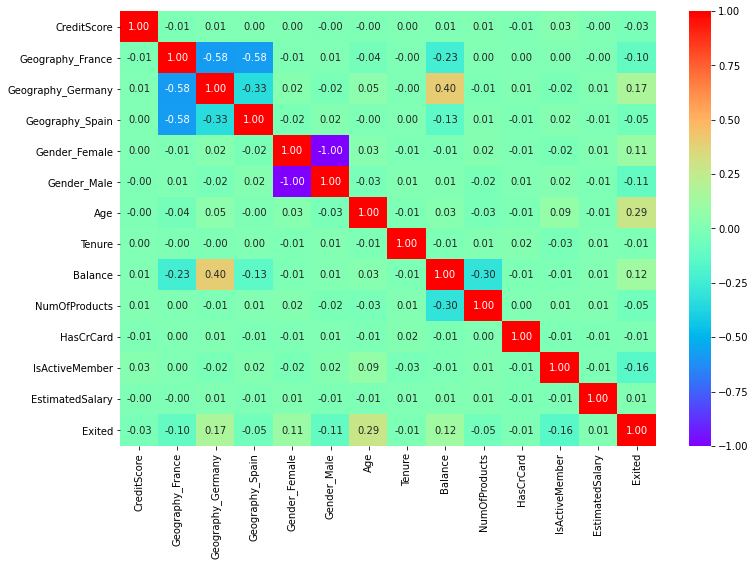

In [25]:
# Looking for correlation Heatmap  ---- Below plot and other plots shows Cement and Strength has highest correlation 0.5
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,fmt='.2f',cmap='rainbow', )
plt.show()

Normalize Test and Tra

In [26]:
X_data = data.iloc[:, :-1]  # selecting all input variables in X_data
y_data = data.iloc[:,-1]    # selecting the target variable "Exited" in y_data

In [27]:
X_data.shape

(10000, 13)

In [28]:
X_data.head()

,CreditScore,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619.0,1.0,0.0,0.0,1.0,0.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88
1,608.0,0.0,0.0,1.0,1.0,0.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58
2,502.0,1.0,0.0,0.0,1.0,0.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57
3,699.0,1.0,0.0,0.0,1.0,0.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63
4,850.0,0.0,0.0,1.0,1.0,0.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10


In [29]:
y_data = data.iloc[:,-1] # target variable

In [30]:
y_data.shape

(10000,)

In [31]:
y_data.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: Exited, dtype: float64

### Split Test and Training Set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [33]:
X_train = preprocessing.normalize(X_train)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)


### Creating a model

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation


In [35]:
model = Sequential()


### Adding layers [layers and activations]

Keras layers can be added to the model
As this is a classification problem, sigmoid layer (softmax for multi-class problems) has been added


In [36]:
model.add(Dense(64, input_shape = (13,), activation = 'relu'))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))

### Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated


In [37]:
sgd = optimizers.Adam(lr = 0.001)

In [38]:
model.compile(optimizers = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])

### Summary of the model

In [39]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


### Training [Forward pass and Backpropagation]

Training the model

In [40]:
model.fit(X_train, y_train.values, batch_size = 700, epochs = 29, verbose = 1) 

Train on 8000 samples
Epoch 1/29
8000/8000 [==============================] - 1s 154us/sample - loss: 0.6079 - accuracy: 0.7225
Epoch 2/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.5193 - accuracy: 0.7968
Epoch 3/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.5056 - accuracy: 0.7968
Epoch 4/29
8000/8000 [==============================] - 0s 6us/sample - loss: 0.5018 - accuracy: 0.7968
Epoch 5/29
8000/8000 [==============================] - 0s 6us/sample - loss: 0.5000 - accuracy: 0.7968
Epoch 6/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.4995 - accuracy: 0.7968
Epoch 7/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.4991 - accuracy: 0.7968
Epoch 8/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.4987 - accuracy: 0.7968
Epoch 9/29
8000/8000 [==============================] - 0s 5us/sample - loss: 0.4988 - accuracy: 0.7968
Epoch 10/29
8000/8000 [=================

### Evaluation
Keras model can be evaluated with evaluate() function

Evaluation results are contained in a list



In [41]:
X_test = preprocessing.normalize(X_test)

In [42]:
results = model.evaluate(X_test, y_test.values)


2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [43]:
print(model.metrics_names)
print (results)    

['loss', 'accuracy']
[0.49801729583740234, 0.7945]


### Confusion Matrix and Model Performance Evaluation 

In [44]:
Y_pred_cls = model.predict_classes(X_test, batch_size=200, verbose=0)
Y_pred_cls=(Y_pred_cls>0.5)                                                   # Prediction using 0.5 threshold used > 0.5
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))
confusion_matrix(y_test.values, Y_pred_cls)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1589,    0],
       [ 411,    0]])

In [ ]:
Confusion Matrix Model Accuracy = 0.7945 is quite good. 

Model Evalution : 
Confusion Matrix Model Accuracy = 0.7945 is quite good. 
It indicates the customer bank churn True Positive= 1589 out of 10,000 rows of sample data provided.
This has been evaluated with all input features in the csv file data set.
The customer tenure with the bank is steady but has drop in the initial year and the 10 year. indicating the customes have stayed with the bank for longer duration after year 1 and most likey to leave more around 10th year. 
To hold the customers for longer and reduce the churn rate - the bank can create new marketing plans and offer more benefits compared to other banks in the market.